# Class imbalance ⚖️



## After participating in this session, you will:
### - understand that imbalanced classification problems often value false-positive classification errors differently from false negatives, which imply considerable complications. 📲
### - be able to name and explain the intuition behind "cost sensitivity" as an approach to handling class imbalance
- Cost-sensitive learning is a subfield of machine learning that involves explicitly defining and using costs when training machine learning algorithms.💻
- Cost-sensitive techniques may be divided into three groups, including data sampling, algorithm modifications, and ensemble methods. 📊
### - be able to name and explain the intuition behind ROC AUC as a useful metric of classifiers trained on imbalanced datasets

In [5]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import where
from numpy import unique
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import vstack

from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

## What is class imbalance and why could it be a problem for making predictions?

In [6]:
# generate dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1, cluster_std=3)

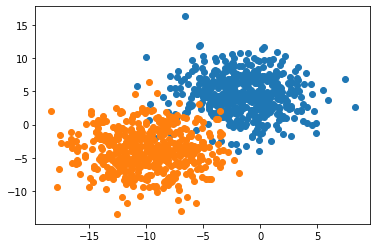

In [7]:
# create scatter plot for samples from each class
for class_value in range(2):
	# get row indexes for samples with this class
	row_ix = where(y == class_value)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

### Compare this with an "imbalanced" dataset:

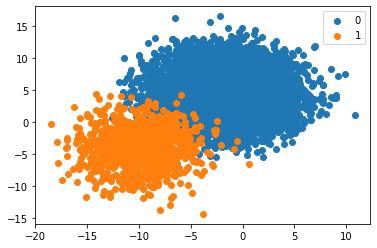

In [8]:
# create a dataset with a given class distribution
def get_dataset(proportions):
	# determine the number of classes
	n_classes = len(proportions)
	# determine the number of examples to generate for each class
	largest = max([v for k,v in proportions.items()])
	n_samples = largest * n_classes
	# create dataset
	X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=2, random_state=1, cluster_std=3)
	# collect the examples
	X_list, y_list = list(), list()
	for k,v in proportions.items():
		row_ix = where(y == k)[0]
		selected = row_ix[:v]
		X_list.append(X[selected, :])
		y_list.append(y[selected])
	return vstack(X_list), hstack(y_list)

# scatter plot of dataset, different color for each class
def plot_dataset(X, y):
	# create scatter plot for samples from each class
	n_classes = len(unique(y))
	for class_value in range(n_classes):
		# get row indexes for samples with this class
		row_ix = where(y == class_value)[0]
		# create scatter of these samples
		plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(class_value))
	# show a legend
	plt.legend()
	# show the plot
	plt.show()

# define the class distribution
proportions = {0:10000, 1:1000}   # from my dataset, make every 
# generate dataset
X, y = get_dataset(proportions)
# plot dataset
plot_dataset(X, y)

### Compare this to an even more unevenly distributed classes:

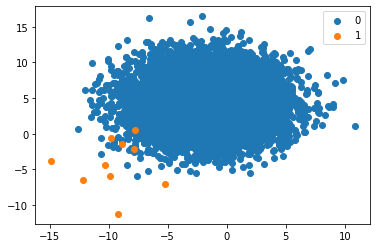

In [9]:
# define the class distribution
proportions = {0:10000, 1:10}
# generate dataset
X, y = get_dataset(proportions)
# plot dataset
plot_dataset(X, y)

### Challenges to make correct predictions with imbalanced datasets are potentially increased by
### - dataset size and by ❗️pending plot❗️
### - label noise ❗️pending plot❗️

## Let's use the creditcard dataset (see XXX)

In [ ]:
df = pd.read_csv("../data/creditcard.zip", index_col=0)
df.head(2)

In [ ]:
df.shape

In [ ]:
X = df.drop(["Class"], axis = 1)
X.columns
X.shape

y = df["Class"]
y.shape

## Why is it a Problem?

- Because the classifier has an "incentive" to rather predict class 0. It just shows up so much more.


In [ ]:
df["Class"].value_counts() / df.shape[0]

- Because of class imbalance in the dataset, any model will be a lot more exposed to the majority class ("non-event", "negative class" or "0") => predictions will be biased towards majority class.
- Even a simple dummy model reflects this: generalizing that there a NO fraud cases whatsoever implies an error rate of only 1% => why invest in preparing data, training model, evaluate model, deploy and maintain it??


- in addition, in imbalanced datasets, not all metrics are created equal
- e.g, use accuracy as metric for evaluating a baseline model => manually:

In [ ]:
TP = 0                      # dummy model states there are 0 positives, but in reality there ARE positives => 0 predictions re positive class is true
FP = 0.001727               # dummy model states there are 0 positives, but in reality there ARE positives => 0.001727 predictions re positive class are false
TN = 0.998273               # dummy model states there are 100% negatives, but in reality there 0.998273 negatives => 0.998273 are true predictions re negative class
FN = 0                      # dummy model states there are 100% negatives, but in reality there 0.998273 negatives => 0.001727 are false predictions re negative class

In [ ]:
accuracy = (0 + 0.998273)/(0+0.001727+0.998273+0)
accuracy

- accuracy using scikit learn's accuracy_score():

In [ ]:
y_pred = np.zeros(284807)
y_true = y


In [ ]:
accuracy_score(y_true, y_pred)


## In other words: if we use accuracy as a metric, we could conclude that the dummy model actually performs quite well (counterintuitive, since we know that there IS a minority group within our dataset)!

## How can we deal with these challenges?

### 1. Compare models and select best-performing one 🤓
### 2. Use the right evaluation metrics 🕙 🕞 🕚
### 3. Resample data 📲
### 4. Apply cost-sensitive learning 🔨💰

## Cost-sensitive Learning 🔨💰

### "Most machine learning algorithms assume that all misclassification errors made by a model are equal. This is often not the case for imbalanced classification problems where missing a positive or minority class case is worse than incorrectly classifying an example from the negative or majority class. There are many real-world examples, such as detecting spam email, diagnosing a medical condition, or identifying fraud. In all of these cases, a false negative (missing a case) is worse or more costly than a false positive." - Jason Brownlee in "Imbalanced Classification with Python".

-  In practice: consider the loss that one single fraud case can have on a whole financial institution (e.g. correspondent LLPs), or for that matter: many small fraud cases accumulated. Even if the fraud is detected, financial institutions suffer of "reputation risk", which in the case increases by higher order of magnitudes (leading in the worst case to bank runs).

### "Cost-sensitive learning is a subfield of machine learning that takes the costs of prediction errors (and potentially other costs) into account when training a machine learning model. It is a field of study that is closely related to the field of imbalanced learning that is concerned with classification on datasets with a skewed class distribution. As such, many conceptualizations and techniques developed and used for cost-sensitive learning can be adopted for imbalanced classification problems. In this tutorial, you will discover a gentle introduction to cost-sensitive learning for imbalanced classification."  - Jason Brownlee in "Imbalanced Classification with Python".

### LogReg WITHOUT weights assigned to cost function - formally:

$$ \min \sum_{i=1}^{n} - (log(yhat_{i}) * y_{i} + log(1 - yhat_{i}) * (1 - y_{i}))$$ 

### LogReg WITHOUT weights assigned to cost function - defining, fitting and evaluating the model:

In [ ]:
LogReg_unweighted = LogisticRegression(solver="lbfgs")    # instantiating the model

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # x-validation

In [ ]:
scores = cross_val_score(LogReg_unweighted, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)  # defining evaluation metric ("ROC AUC")

In [ ]:
print('Mean ROC AUC: %.3f' % mean(scores)) 

### Mean ROC AUC = 0.917...but: what DOES this mean? 

## Use the right evaluation metrics 🕙 🕞 🕚: the ROC AUC

#### Splitting data into training and test set

In [ ]:
X = df.iloc[:,:-1] 
y = df["Class"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y) # remember: you set "stratify" so that train data and labelled data have the same "proportions" re classes...
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
LogReg_unweighted.fit(X_train, y_train)

In [ ]:
ROC_LogReg_unweighted = plot_roc_curve(LogReg_unweighted, X_test, y_test)
plt.show()


### Back to LogReg, now WITH weights - formally:

$$ \min \sum_{i=1}^{n} - (w_{0} * log(yhat_{i}) * y_{i} + w_{1} * log(1 - yhat_{i}) * (1 - y_{i}))$$ 

### LogReg WITH weights assigned to cost function - defining, fitting and evaluating the model:

In [ ]:
weights = {0:0.01, 1:1.0} # note the weights assigned to loss function, whereby positive cases have a proportionally higher contribution to loss

In [ ]:
LogReg_weighted = LogisticRegression(solver="lbfgs", class_weight=weights) # note the explicit spec of the "weights" param, as opposed to above

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(LogReg_weighted, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)  # defining evaluation metric ("ROC AUC")

In [ ]:
print('Mean ROC AUC: %.3f' % mean(scores)) 

In [ ]:
# models = ["LogReg_unweighted", "LogReg_weighted"]

# print(f"Comparing ROC AUC of LogReg models - without and with weighting of cost function.") 

# for name, model in models:                        
    
#     test_score = model.score(Xtest, ytest)
#     print(f"The test score for {model} is {test_score}.")
    
#     if test_score < train_score:
#         print(f"The {model} tends to overfit.")
    
#     elif train_score < test_score:
#         print(f"{model} tends to underfit but outperforms dummy model!") 

### Clearly, weighting cost function improves performance of LogReg on this imbalanced dataset (0.957 vs 0.917)!

In [ ]:
LogReg_weighted.fit(X_train, y_train)

# LogReg_unweighted.fit(X_train, y_train)

In [ ]:
ax = plt.gca()

ROC_LogReg_weighted = plot_roc_curve(LogReg_weighted, X_test, y_test, ax=ax, alpha=0.8)
ROC_LogReg_unweighted.plot(ax=ax, alpha=0.8)

plt.show() 

#### compare a neural network the same way => eventually, you will have to go to google colab to do this